In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, m_e, m_p
from scipy.constants import e as q_e

In [53]:
"""Utility random functions for 3D MCC simulation"""
def random_direction(nsampl, l=1):
    """generate nsampl 3D vectors with random directions and length l"""
    v = np.zeros((nsampl, 3))
    cos_theta = 1 - 2*np.random.uniform(size = nsampl)
    sin_theta = np.sqrt(1-cos_theta**2)
    phi = 2*np.pi*np.random.uniform(size = nsampl)

    v[:,0] = l*cos_theta
    v[:,1] = l*sin_theta*np.sin(phi)
    v[:,2] = l*sin_theta*np.cos(phi)
    return v

def random_rotate(vectors):
    """independently randomly rotate an array of 3D vectors"""
    lens = np.linalg.norm(vectors, axis=1)
    return random_direction(len(lens), lens)

def random_maxwell_v_component(T, M, nsampl):
    return np.random.normal(0, np.sqrt(k*T/M), nsampl)

In [54]:
class MultiChoose:
    """
    Sequentially choose n samples from multinomial distribution.
    __call__ method returns all elements of chosen type with probability prob.
    The probability can be element-specific.
    """
    def __init__(self, n):
        self.xi = np.random.uniform(0, 1, n)
        self.prob = np.zeros(n)
        
    def __call__(self, prob, mask=None):
        prob_new = self.prob + prob
        i = (self.xi > self.prob) & (self.xi < prob_new)
        self.prob = prob_new
        
        if mask is not None:
            ii = np.zeros_like(mask)
            ii[mask] = i
            i = ii

        return i        

In [55]:
def maximize(func, a, b, nsampl=100):
    """Maximization function suitable for cross section data."""
    # find approximate maximum by brute force search
    x = np.logspace(np.log10(a), np.log10(b), nsampl)
    i = np.argmax(func(x))
    
    # and fine-tune using minimize_scalar
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(lambda x: -func(x), bounds=(x[max(0, i-1)], x[min(nsampl-1, i+1)]), method="Bounded")
    return res.x, func(res.x)

In [56]:
def load_CS(filename, process, species):
    """
    Load cross section and energy loss from txt file
    downloaded from lxcat.net.
    """
    with open(filename) as f:
        lines = iter(f.read().splitlines())
        
        for line in lines:
            if line == process and next(lines) == species:
                break
                
        DE = float(next(lines))
        
        for line in lines:
            if "-----" in line: break
        
        CS = []
        for line in lines:
            if "-----" in line: break
            CS.append(list(map(float,line.split())))

    return DE, np.array(CS)

In [57]:
class Interaction:
    def __init__(self, name, collision_type, sigma, DE, particle1, particle2):
        """
        sigma: cross section in m2
        DE: energy loss in eV
        """
        if sigma[0,0] > 0: sigma = np.vstack(([0,0], sigma))
        self.name = name
        self.collision_type = collision_type
        self.DE = DE
        self.E = sigma[:,0]
        self.sigma = sigma[:,1]
        self.p1 = particle1
        self.p2 = particle2
        self.mu = particle1.M*particle2.M / (particle1.M+particle2.M)
        self.v = np.sqrt(2*self.E*q_e/self.mu)
        
        from scipy.interpolate import interp1d
        self.sigma_v = interp1d(self.v, self.sigma*self.v)
        
    def scatter(self, v2, v_rel_norm, mask=slice(None)):
        v1 = self.p1.v[mask]
        n = len(v1)
        m1 = self.p1.M
        m2 = self.p2.M
        
        # account for energy loss
        if self.DE != 0:
            E = 0.5*self.mu*v_rel_norm**2 - self.DE*q_e
            if self.collision_type == "ionization": # only the primary electrons are tracked in case of ionization
                E = E*np.random.uniform(0, 1, n)
            v_rel_norm = np.sqrt(2*E/self.mu)
            
        # random rotation
        v_rel = random_direction(n, v_rel_norm)
        v1_cm = v_rel * m2 / (m1 + m2)

        # transform to lab frame
        v_cm = (v1*m1 + v2*m2)/(m1+m2)
        self.p1.v[mask] = v1_cm + v_cm

In [58]:
class Electrons:
    def __init__(self, n, Emax):
        self.name="e"
        self.n = n
        self.M = m_e
        self.Q = q_e
        self.v = np.zeros((n, 3))
        self.t = np.zeros(n)
        self.tau = np.zeros(n)
        self.type = "particle"
        self.Emax = Emax
        
    def init_thermal_velocity(self, T):
        self.v = random_maxwell_v_component(T, self.M, (self.n, 3))
        
    def init_monoenergetic(self, EeV):
        vtot = np.sqrt(2*EeV*q_e/self.M)
        self.v = random_direction(self.n, vtot)
        
    def init_tau(self, tau):
        self.tau = -tau*np.log(np.random.uniform(0, 1, self.n))
        
    def energy(self):
        return 0.5*self.M*np.sum(self.v**2, axis=1)
    
    def advance(self, E, tmax):
        t_advance = np.minimum(self.tau, tmax-self.t)
        self.v[:,0] += self.Q*E/self.M*t_advance
        self.t += t_advance

In [59]:
class Neutrals:
    def __init__(self, T, M, n, name):
        """
        n: number density in m-3
        """
        self.name = name
        self.M = M
        self.T = T
        self.n = n
        self.type = "continuum"
        
    def random_sample(self, n):
        return random_maxwell_v_component(self.T, self.M, (n, 3))

In [60]:
from collections import OrderedDict
class Interactions:
    def __init__(self, p1):
        # dictionary of interactions. Contains lists of interactions where
        # keys are scattering partner names
        self.p1 = p1
        self.interactions = {}
        self.specdict = OrderedDict({p1.name: p1})
        
    def add_interaction(self, interaction):
        p2name = interaction.p2.name
        self.specdict[p2name] = interaction.p2
        self.interactions[p2name] = self.interactions.get(p2name, []) + [interaction]
        
    def svmax_find(self):
        self.svmax = {}
        for p2name, interaction_list in self.interactions.items():
            def sigma_v_sum(v):
                return sum(i.sigma_v(v) for i in interaction_list)
            vmax = np.sqrt(2*self.p1.Emax*q_e/self.p1.M)
            self.svmax[p2name] = maximize(sigma_v_sum, vmax/1e6, vmax)[1]
        
    def tau_recalculate(self):
        self.rates = OrderedDict((k, svmax*self.specdict[k].n) for k, svmax in self.svmax.items())
        self.rate = sum(self.rates.values())
        self.tau = 1/self.rate
        return self.tau
    
    def scatter(self, mask=None, debug=False):
        if mask is None: mask = np.ones(len(self.p1.v), dtype=bool)
        
        # select collision species
        n = np.count_nonzero(mask) # not very efficient
        species_choose = MultiChoose(n)
        for p2name, rate in self.rates.items():
            ispec = species_choose(rate/self.rate, mask)
            nspec = np.count_nonzero(ispec)
            
            # collision selection
            if nspec > 0:
                # generate partner
                v1 = self.p1.v[ispec]
                v2 = self.specdict[p2name].random_sample(nspec)
                v_rel_norm = np.linalg.norm(v1 - v2, axis=1)

                # select collision
                collision_choose = MultiChoose(nspec)
                for interaction in self.interactions[p2name]:
                    icoll = collision_choose(interaction.sigma_v(v_rel_norm)/self.svmax[p2name], ispec)
                    if debug:
                        print(interaction.name, nspec, np.count_nonzero(icoll))
                    interaction.scatter(v2[icoll[ispec]], v_rel_norm[icoll[ispec]], icoll)

In [46]:
electrons = Electrons(60000, 20)
electrons.init_thermal_velocity(10000)
Efield = 1e2
helium = Neutrals(300., 4*m_p, 3.21e22, "He")

In [24]:
electron_interactions = Interactions(electrons)

DE, CS = load_CS("CS_e_He_Phelps.txt", "EFFECTIVE", "He")
electron_interactions.add_interaction(Interaction("e_He_elastic", "elastic", CS, 0, electrons, helium))

DE, CS = load_CS("CS_e_He_Phelps.txt", "EXCITATION", "He -> He*(19.8eV)")
electron_interactions.add_interaction(Interaction("e_He_excitation", "excitation", CS, DE, electrons, helium))

DE, CS = load_CS("CS_e_He_Phelps.txt", "IONIZATION", "He -> He^+")
electron_interactions.add_interaction(Interaction("e_He_ionization", "ionization", CS, DE, electrons, helium))

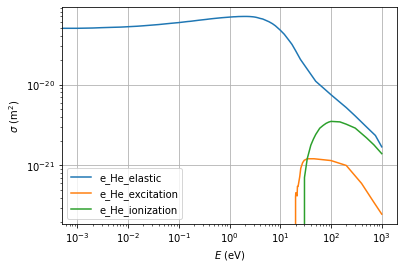

In [25]:
f, ax = plt.subplots(1,1)
for p2name, interactions in electron_interactions.interactions.items():
    for interaction in interactions:
        ax.plot(interaction.E, interaction.sigma, label=interaction.name)
        
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$E\\ \\rm(eV)$")
ax.set_ylabel("$\\sigma\\ \\rm(m^2)$")
ax.legend()
ax.grid()

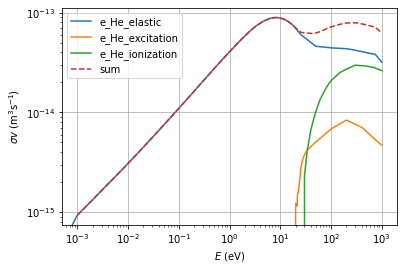

In [26]:
f, ax = plt.subplots(1,1)
for p2name, interactions in electron_interactions.interactions.items():
    for interaction in interactions:
        ax.plot(interaction.E, interaction.sigma_v(interaction.v), label=interaction.name)

    E = np.logspace(-3, 3)
    v = np.sqrt(2*E*q_e/interaction.mu)
    ax.plot(E, sum([i.sigma_v(v) for i in interactions]), "--", label="sum")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$E\\ \\rm(eV)$")
ax.set_ylabel("$\\sigma v\\ \\rm(m^3 s^{-1})$")
ax.legend()
ax.grid()

In [28]:
electron_interactions.svmax_find()
print(electron_interactions.svmax)
electron_interactions.tau_recalculate()

{'He': 8.975404615832605e-14}


1.1141558991513331e-10

In [29]:
#%%timeit
tmax = 100e-9
ncol = 0
E = 1000
electrons.t[:] = 0
while np.any(electrons.t < tmax):
    electrons.init_tau(electron_interactions.tau)
    electrons.advance(E, tmax)
    ncol += np.count_nonzero(electrons.t < tmax)
    electron_interactions.scatter(electrons.t < tmax, debug=False)
print(electrons.energy().mean()/q_e)
ncol

3.3616285026230175


8976643

In [34]:
electrons.init_thermal_velocity(10000)
electrons.t[:] = 0


tax = np.r_[np.linspace(0, 5e-8, 20), np.linspace(5e-8, 5e-7, 50)]
energies = np.array([])
Emeans = [electrons.energy().mean()]
t_equilib = 2e-8
for tmax in tax[1:]:
    while np.any(electrons.t < tmax):
        electrons.init_tau(electron_interactions.tau)
        electrons.advance(Efield, tmax)
        electron_interactions.scatter(electrons.t < tmax)
    if tmax >= t_equilib:
        energies = np.append(energies, electrons.energy())
    Emeans.append(electrons.energy().mean())

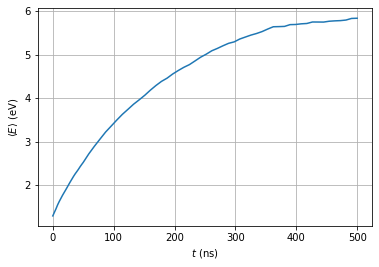

In [35]:
plt.plot(tax*1e9, np.array(Emeans)/q_e)
plt.xlabel("$t\\ \\rm (ns)$")
plt.ylabel("$\\left<E\\right>\\ \\rm (eV)$")
plt.grid()

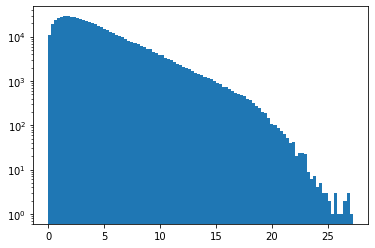

In [36]:
plt.hist(energies/q_e, bins=100, label="E=%g eV"%(electrons.energy().sum()/electrons.n/q_e))
plt.yscale("log")

In [67]:
electrons = Electrons(10000, 20)
electrons.init_thermal_velocity(40000)
E_Td = 15
n = 1e17*1e6
n = 3.21e22
E = E_Td*n/1e21
E = 1e2
argon = Neutrals(300., 40*m_p, n, "Ar")
print(E)

100.0


In [68]:
electron_interactions = Interactions(electrons)

DE, CS = load_CS("CS_e_Ar_Phelps.txt", "EFFECTIVE", "Ar")
electron_interactions.add_interaction(Interaction("e_Ar_elastic", "elastic", CS, 0, electrons, argon))

DE, CS = load_CS("CS_e_Ar_Phelps.txt", "EXCITATION", "Ar -> Ar*(11.5eV)")
electron_interactions.add_interaction(Interaction("e_Ar_excitation", "excitation", CS, DE, electrons, argon))

DE, CS = load_CS("CS_e_Ar_Phelps.txt", "IONIZATION", "Ar -> Ar^+")
electron_interactions.add_interaction(Interaction("e_Ar_ionization", "ionization", CS, DE, electrons, argon))

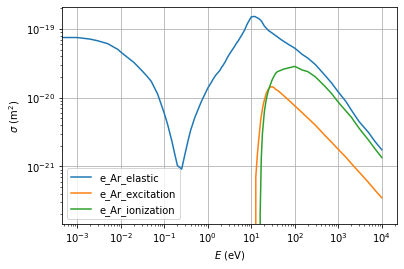

In [69]:
f, ax = plt.subplots(1,1)
for p2name, interactions in electron_interactions.interactions.items():
    for interaction in interactions:
        ax.plot(interaction.E, interaction.sigma, label=interaction.name)
        
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$E\\ \\rm(eV)$")
ax.set_ylabel("$\\sigma\\ \\rm(m^2)$")
ax.legend()
ax.grid()

In [70]:
electron_interactions.svmax_find()
electron_interactions.tau_recalculate()

9.244404921462867e-11

In [71]:
tax = np.r_[np.linspace(0, 2e-7, 10), np.linspace(2e-7, 50e-7, 100)]
energies = np.array([])
Emeans = [electrons.energy().mean()]
t_equilib = 2e-7
for tmax in tax[1:]:
    while np.any(electrons.t < tmax):
        electrons.init_tau(electron_interactions.tau)
        electrons.advance(E, tmax)
        electron_interactions.scatter(electrons.t < tmax)
    if tmax >= t_equilib:
        energies = np.append(energies, electrons.energy())
    Emeans.append(electrons.energy().mean())

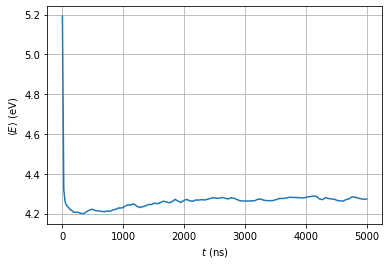

In [72]:
plt.plot(tax*1e9, np.array(Emeans)/q_e)
plt.xlabel("$t\\ \\rm (ns)$")
plt.ylabel("$\\left<E\\right>\\ \\rm (eV)$")
plt.grid()

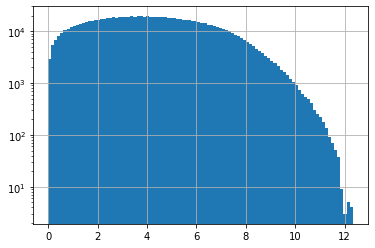

In [73]:
plt.hist(energies/q_e, bins=100, label="E=%g eV"%(electrons.energy().sum()/electrons.n/q_e))
plt.yscale("log")
plt.grid()

In [32]:
# reset simulation
#np.random.seed(16)
electrons.init_thermal_velocity(10000)
electrons.t[:] = 0

In [33]:
tax = np.r_[np.linspace(0, 2e-8, 20)]
energies = np.array([])
Emeans = [electrons.energy().mean()]
t_equilib = 1e-6
for tmax in tax[1:]:
    while np.any(electrons.t < tmax):
        electrons.init_tau(electron_interactions.tau)
        electrons.advance(E, tmax)
        electron_interactions.scatter(electrons.t < tmax)
    if tmax >= t_equilib:
        energies = np.append(energies, electrons.energy())
    Emeans.append(electrons.energy().mean())

In [44]:
tax2 = np.r_[np.linspace(2e-8, 1e-7, 50)]
tax = np.r_[tax, tax2]
energies = np.array([])
Emeans = [electrons.energy().mean()]
t_equilib = 2e-8
for tmax in tax2[1:]:
    while np.any(electrons.t < tmax):
        electrons.init_tau(electron_interactions.tau)
        electrons.advance(E, tmax)
        electron_interactions.scatter(electrons.t < tmax)
    if tmax >= t_equilib:
        energies = np.append(energies, electrons.energy())
    Emeans.append(electrons.energy().mean())

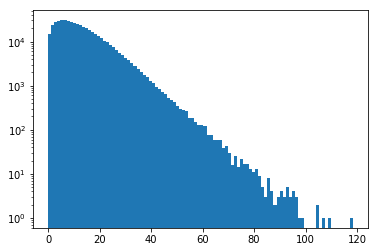

In [39]:
#bins = np.linspace(2e-19, 10e-14, 100)
plt.hist(energies/q_e, bins=100, label="E=%g eV"%(electrons.energy().sum()/electrons.n/q_e))
plt.yscale("log")

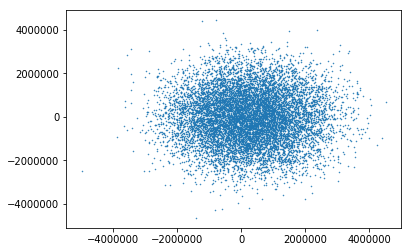

In [40]:
plt.plot(electrons.v[:,[0]], electrons.v[:,[1]], ".", ms=1)